# Regularized Regression: L$_1$ and L$_2$
#### by Elizabeth Barnes

Avoiding overfitting with regularization.

In [90]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

#.............................................
# IMPORT STATEMENTS
#.............................................
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets, linear_model
import scipy.io as io
import copy as copy
import csv

from sklearn import preprocessing

import datetime
import pandas as pd
import xarray as xr

#.............................................
# PLOTTING COMMANDS
#.............................................
import matplotlib as mpl
import cartopy as ct

# set figure defaults
mpl.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = (12.0/2, 8.0/2)

## Example: when $L_1$ makes sense

Let's grab some data from Christman field.

In [101]:
filename = 'data/christman_2016.csv'
data_input = np.genfromtxt(filename, delimiter = ',')

# grab the variables I want, but do not include day of year or time of day since
# SOM takes the average of the values and these are cyclic
grab_indices = [2,3,5,9,10,11] 

data = data_input[:,grab_indices]

names_input = ['date','time','temp (F)', 'RH (%)', 'DewPt (F)','Wind (mph)', 'Dir (deg.)', 'Gust (mph)', 'Gust Dir (deg.)','Pres (mb)', 'Solar (W/m^2)','Precip (in)']
names = [names_input[i] for i in grab_indices]

# convert precip inches to mm
data[:,[i for i, s in enumerate(names) if 'Precip' in s]] = data[:,[i for i, s in enumerate(names) if 'Precip' in s]]*25.4
names[names.index('Precip (in)')] = 'Precip (mm)'

print(np.shape(data))
print(names)

(8784, 6)
['temp (F)', 'RH (%)', 'Wind (mph)', 'Pres (mb)', 'Solar (W/m^2)', 'Precip (mm)']


Since all of the units are different, we will standardize everything here. Note that we can also use the "normalize=True" function in the scikit learn functions too. 

In [102]:
# standardize the data
data_std = preprocessing.scale(data)

print(data_std.mean(axis=0))
print(data_std.std(axis=0))

[ 2.58849813e-16 -6.47124532e-17 -6.47124532e-18 -1.65081468e-14
 -8.08905665e-17 -1.45603020e-17]
[1. 1. 1. 1. 1. 1.]


In [129]:
# predict temperature
y = data_std[:,0]

# define predictors (all 5 other variables)
x = data_std[:,1:]

Okay - let's fit the line and look how different forms of regularization impact the solution.

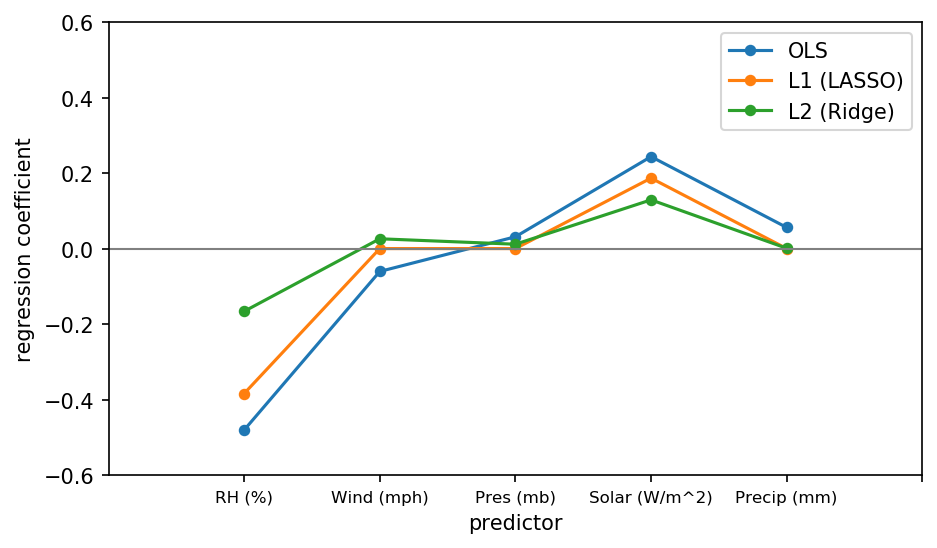

In [147]:
#--------------------------------------
# Regression Fitting
regOLS = linear_model.LinearRegression(normalize=True)
regL1 = linear_model.Lasso(alpha=.001,normalize=True)
regL2 = linear_model.Ridge(alpha=2.,normalize=True)

regOLS.fit(x,y)
regL1.fit(x,y)
regL2.fit(x,y)
#--------------------------------------

plt.figure(figsize=(7,4))
plt.plot(regOLS.coef_,'.-', markersize=9, label='OLS')
plt.plot(regL1.coef_,'.-', markersize=9, label='L1 (LASSO)')
plt.plot(regL2.coef_,'.-', markersize=9, label='L2 (Ridge)')
plt.xticks(np.arange(0,6), labels=names[1:], fontsize=8)
plt.xlabel('predictor')
plt.ylabel('regression coefficient')
plt.axhline(y=0,color='gray', linewidth=1)
plt.legend()
plt.xlim(-1,5)
plt.ylim(-.6,.6)
plt.show()


## Example: when Ridge ($L_2$) makes sense

In [52]:
DATA = io.loadmat('data/z500_daily.mat')    
Xall = np.array(DATA['X'])
LAT = np.array(DATA['LAT'])[0,:]
LON = np.array(DATA['LONG'])[0,:]
TIME = np.array(DATA['TIME'])
print('data is loaded')

# less data to deal with
X = copy.deepcopy(Xall[:,::4,::4])
LAT = LAT[::4]
LON = LON[::4]

del Xall

data is loaded


In [53]:
# get time vector in order for xarray
dateList = []
for i, junk in enumerate(TIME[:,0]):
    dateList.append(datetime.datetime(int(TIME[i,1]),int(TIME[i,2]),int(TIME[i,3])))
    

In [54]:
# create xarray 
da = xr.DataArray(X,dims=('time','latitude','longitude'),coords={'latitude': LAT, 'longitude': LON, 'time': dateList}, name='z500')

In [61]:
# climatology = da.groupby("time.month").mean("time")
# anomalies = (da.groupby("time.month") - climatology)/da.groupby("time.month").std("time")

climatology_mean = da.groupby("time.month").mean("time")
climatology_std = da.groupby("time.month").std("time")
anomalies = xr.apply_ufunc(
    lambda x, m, s: (x - m) / s,
    da.groupby("time.month"),
    climatology_mean,
    climatology_std,
)

X = da.where(anomalies['time.season'] == 'DJF',drop=True)
print(np.shape(X))

(3038, 16, 30)


In [62]:
# Define the predictand point
y = np.squeeze(X[:,9,1])
print(np.shape(y))

(3038,)


In [63]:
# Define the predictors
x = np.reshape(X.values,(np.shape(X)[0],np.shape(X)[1]*np.shape(X)[2]))
print(x.shape)

(3038, 480)


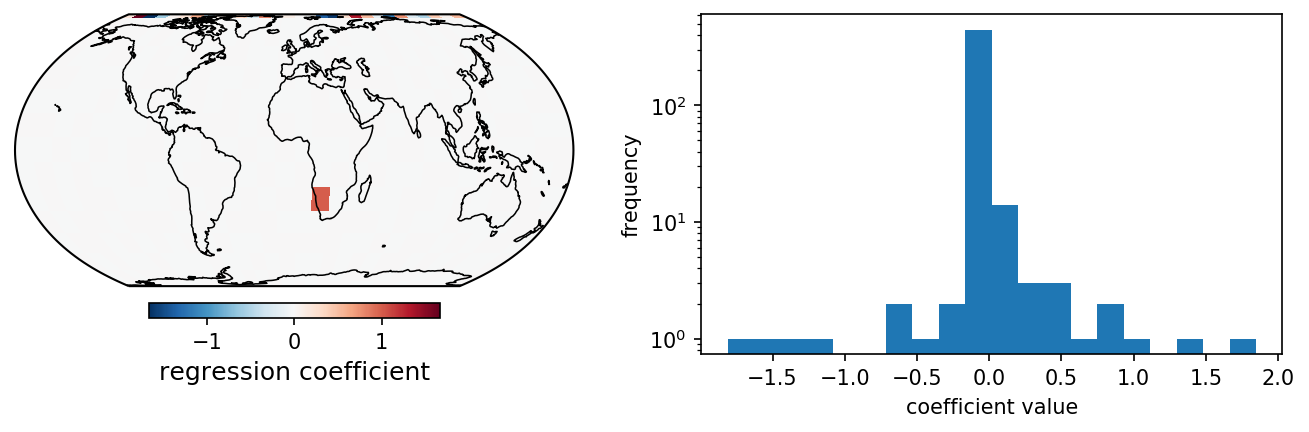

In [88]:
#--------------------------------------
# Regression Fitting
reg = linear_model.LinearRegression()
# reg = linear_model.Lasso(alpha=10.)
# reg = linear_model.Ridge(alpha=1e8)

reg.fit(x,y)
#--------------------------------------

# get rid of line at long = 0.0
data = np.reshape(reg.coef_,(len(da['latitude'].values),len(da['longitude'].values)))
data_cyc = np.append(data,data[:,0:1],axis=1)
lons_cyc = np.append(da['longitude'].values,360.)

# plot the figure of regression coefficients
data_crs = ct.crs.PlateCarree()
plt.figure(figsize=(11,3))
ax = plt.subplot(1,2,1,projection=ct.crs.EqualEarth())
ax.set_global()
ax.coastlines(linewidth = .75)
image = ax.pcolor(lons_cyc, da['latitude'].values, data_cyc, transform=data_crs, cmap='RdBu_r')
cb = plt.colorbar(image, shrink=.5, orientation="horizontal", pad=.05)
cb.set_label('regression coefficient', fontsize=12)
maxval = .9*np.max(reg.coef_[:])
image.set_clim(-maxval,maxval)

plt.subplot(1,2,2)
plt.hist(reg.coef_[:],20)
plt.yscale('log')
plt.xlabel('coefficient value')
plt.ylabel('frequency')
plt.show()